#  Imports

In [1]:
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset


In [3]:

# Cargar datasets sin etiquetas (sólo imágenes)
_train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/train',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    color_mode='rgb', 
    seed=42
)

_val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    color_mode='rgb',
    seed=42
)

_test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/test",
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    color_mode='rgb',
    seed=42
)

#normalizar las imágenes
def normalize_image(image, label=None):
    image = tf.cast(image, tf.float32) / 255.0  # Normalizar a [0, 1]
    return image, label

# Aplicar el mapeo, batching, prefetching
train_dataset = _train_dataset.map(normalize_image).prefetch(tf.data.AUTOTUNE)
val_dataset = _val_dataset.map(normalize_image).prefetch(tf.data.AUTOTUNE)
test_dataset = _test_dataset.map(normalize_image).prefetch(tf.data.AUTOTUNE)

Found 20300 files belonging to 29 classes.
Found 2900 files belonging to 29 classes.
Found 5800 files belonging to 29 classes.


In [4]:
execution_path = os.getcwd()
print(f"El path de la ejecución es: {execution_path}")

El path de la ejecución es: e:\TFM\TFM\normal


In [7]:
# List the contents of the directory
contents = os.listdir(execution_path)
print(f"Contenido de '{execution_path}':")
print(contents)

Contenido de 'e:\TFM\TFM\normal':
['normal.ipynb']


##  Definir modelo

In [6]:
def buildmodel(input_shape=(224, 224, 3), num_classes=29):
    print("🔧 Construyendo un modelo mejorado para RotNet...")
    base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape, weights="imagenet")
    base_model.trainable = False  # Congelar las capas del modelo base
    # descongelar algunas capas del modelo base
    for layer in base_model.layers[0:]:  # Descongelar las últimas 20 capas
        layer.trainable = True

    x= base_model.output
    tf.keras.layers.GlobalAveragePooling2D(),
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    print("✅ Modelo mejorado creado con éxito.\n")
    return model
model = buildmodel()

model.summary()


🔧 Construyendo un modelo mejorado para RotNet...
✅ Modelo mejorado creado con éxito.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
      

## Ejecutar entrenamiento

In [7]:
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print("🚀 Comenzando el entrenamiento...\n")


# history = model.fit(dataset, epochs=100, verbose=2)
history = model.fit(
    test_dataset,
    epochs=50,
    verbose=1,
    validation_data=test_dataset,  # Usar el dataset de validación
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",  # Monitorear la pérdida en los datos de validación
            patience=10,  # Aumentar la paciencia para permitir más iteraciones
            restore_best_weights=True,  # Restaurar los mejores pesos al final
            min_delta=1e-4,  # Mínima mejora requerida para considerar un cambio significativo
            verbose=1  # Mostrar mensajes cuando se active el EarlyStopping
        ),
        tf.keras.callbacks.ModelCheckpoint(
            "best_rotnet_model.keras",
            monitor="val_loss", 
            save_best_only=True,
            verbose=1
        )
    ]
)


print(f"\n✅ Entrenamiento finalizado.")

save_path = "E:/TFM/TFM/normal/model.keras"
model.save(save_path)
print(f"💾 Modelo guardado en: {save_path}")


🚀 Comenzando el entrenamiento...

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 2.7280 - accuracy: 0.5886
Epoch 1: val_loss improved from inf to 2.13969, saving model to best_rotnet_model.keras
91/91 [==============================] - 37s 316ms/step - loss: 2.7280 - accuracy: 0.5886 - val_loss: 2.1397 - val_accuracy: 0.7457
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 1.4808 - accuracy: 0.9002
Epoch 2: val_loss improved from 2.13969 to 1.69997, saving model to best_rotnet_model.keras
91/91 [==============================] - 28s 306ms/step - loss: 1.4808 - accuracy: 0.9002 - val_loss: 1.7000 - val_accuracy: 0.8398
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 1.2737 - accuracy: 0.9616
Epoch 3: val_loss improved from 1.69997 to 1.51690, saving model to best_rotnet_model.keras
91/91 [==============================] - 28s 306ms/step - loss: 1.2737 - accuracy: 0.9616 - val_loss: 1.5169 - val_accuracy: 0.8803
Epoch 4/50
91/91

## Visualizar

<Figure size 1200x1200 with 0 Axes>

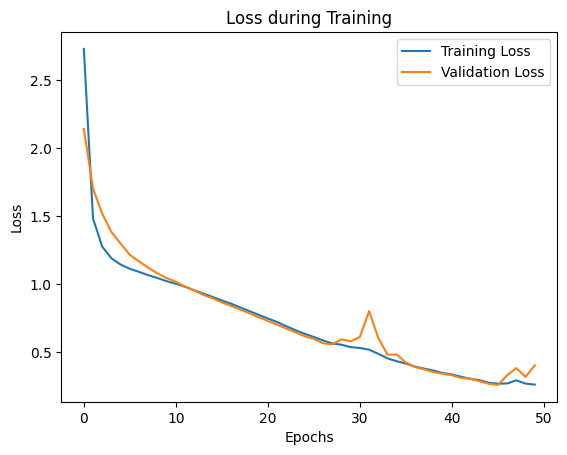

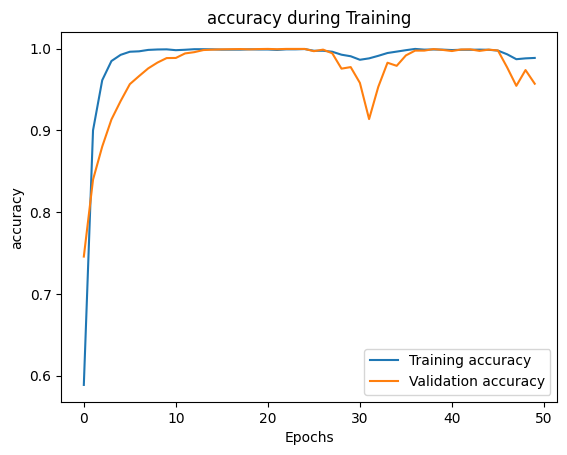

In [8]:
def plot_training_history(history):
    plt.figure(figsize=(12, 12))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('accuracy during Training')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)


1/1 [==============================] - 1s 580ms/step
Accuracy de validación: 0.79


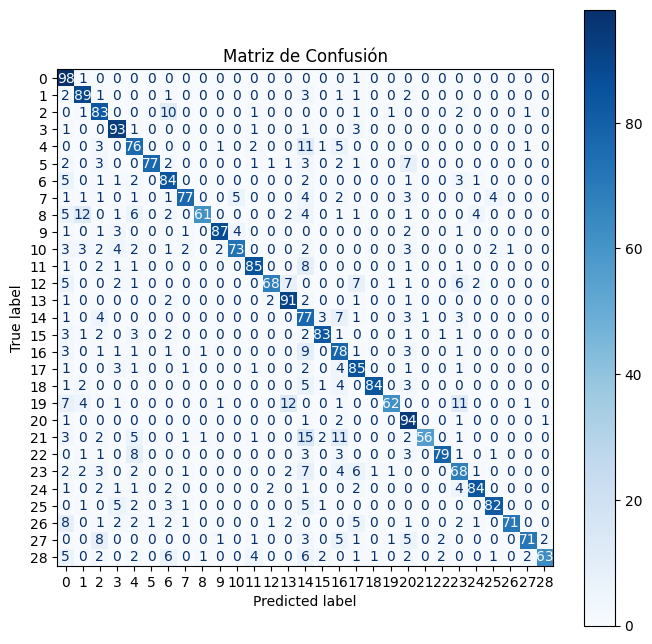

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
model = tf.keras.models.load_model("E:/TFM/TFM/normal/model.keras")
# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
    
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy de validación: {accuracy:.2f}")
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(29))  # Ajusta el rango según tus clases
fig, ax = plt.subplots(figsize=(8, 8))  # Aumentar el tamaño de la figura
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Matriz de Confusión")
plt.show()


1/1 [==============================] - 0s 24ms/step


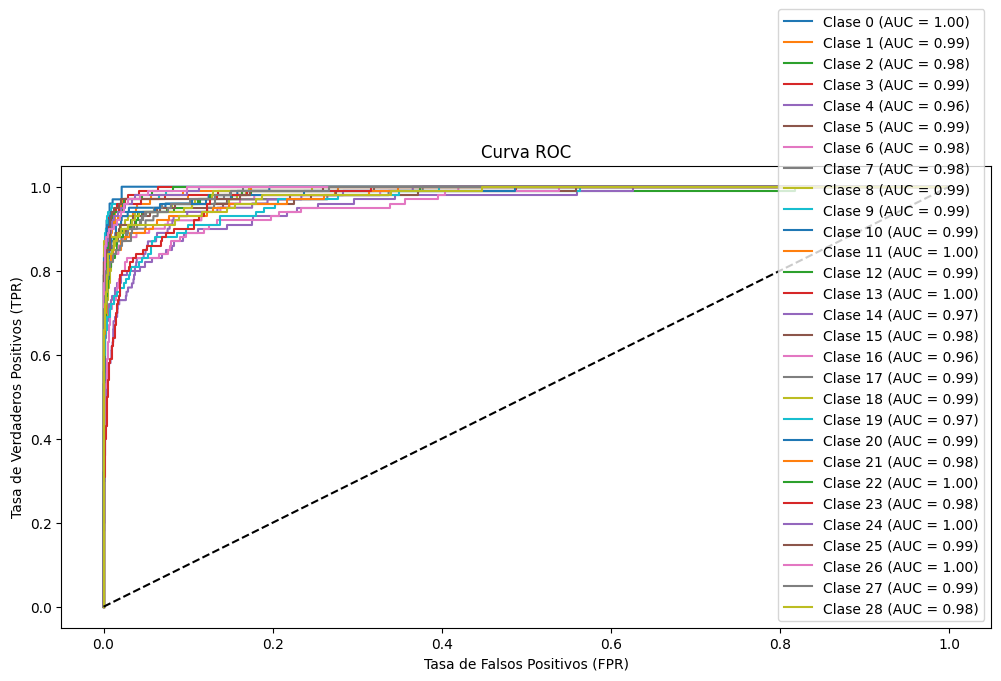

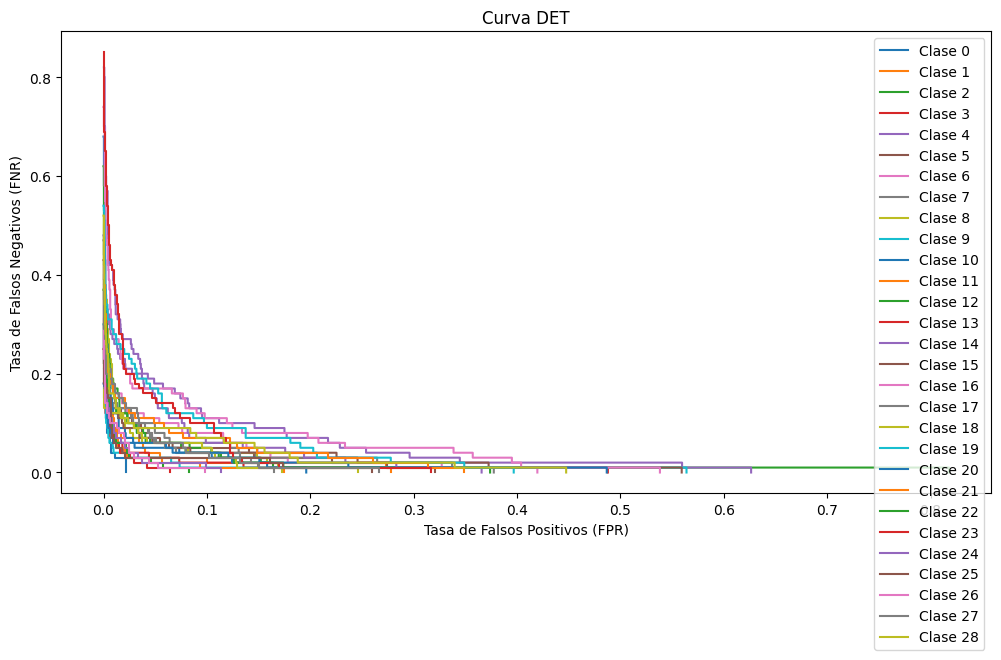

In [10]:
from sklearn.metrics import roc_curve, det_curve, auc
import keras
import matplotlib.pyplot as plt

# Convertir y_true y y_pred a formato binario para cada clase
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

y_true_binary = keras.utils.to_categorical(y_true, num_classes=29)
y_pred_binary = np.array(y_pred)

# Generar la curva ROC y calcular el AUC para cada clase
plt.figure(figsize=(12, 6))
for i in range(29):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva DET para cada clase
plt.figure(figsize=(12, 6))
for i in range(29):
    # Verificar si hay más de una clase en y_true_binary[:, i]
    if len(np.unique(y_true_binary[:, i])) > 1:
        fpr, fnr, _ = det_curve(y_true_binary[:, i], y_pred_binary[:, i])
        plt.plot(fpr, fnr, label=f'Clase {i}')
    else:
        print(f"Clase {i} tiene solo una clase en y_true. No se puede generar la curva DET.")

plt.title('Curva DET')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Falsos Negativos (FNR)')
plt.legend(loc='upper right')
plt.show()

<Figure size 1200x1200 with 0 Axes>

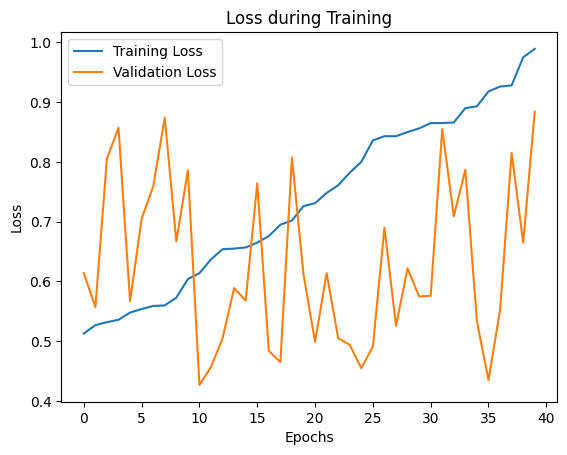

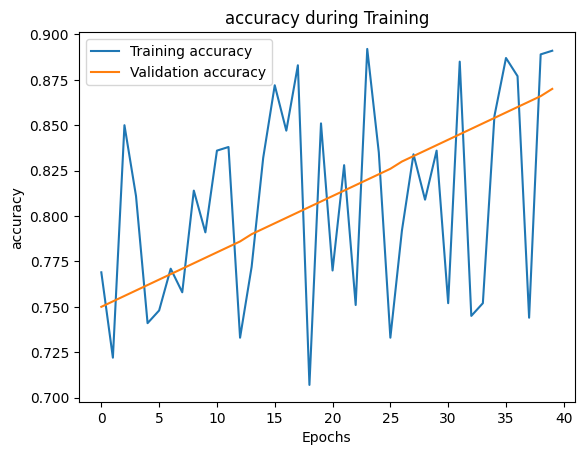

In [2]:
import matplotlib.pyplot as plt
loss=[0.836, 0.800, 0.637, 0.975, 0.559, 0.513, 0.676, 0.536, 0.865, 0.782, 0.573, 0.654, 0.695, 0.532, 0.748, 0.726, 0.989, 0.527, 0.843, 0.856, 0.702, 0.655, 0.665, 0.614, 0.850, 0.761, 0.560, 0.866, 0.731, 0.890, 0.548, 0.928, 0.918, 0.865, 0.657, 0.604, 0.843, 0.926, 0.893, 0.554]
sortd_loss = sorted(loss)
def plot_training():
    plt.figure(figsize=(12, 12))
    
    # Pérdida
    plt.figure()
    plt.plot(sortd_loss, label='Training Loss')
    plt.plot([0.614, 0.557, 0.806, 0.857, 0.567, 0.705, 0.759, 0.874, 0.667, 0.786, 0.427, 0.457, 0.505, 0.589, 0.568, 0.764, 0.484, 0.465, 0.807, 0.612, 0.499, 0.614, 0.505, 0.494, 0.455, 0.491, 0.690, 0.526, 0.622, 0.575, 0.576, 0.855, 0.709, 0.787, 0.533, 0.435, 0.552, 0.815, 0.665, 0.884], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # accuracy
    plt.figure()
    plt.plot([0.769, 0.722, 0.850, 0.811, 0.741, 0.748, 0.771, 0.758, 0.814, 0.791, 0.836, 0.838, 0.733, 0.772, 0.832, 0.872, 0.847, 0.883, 0.707, 0.851, 0.770, 0.828, 0.751, 0.892, 0.835, 0.733, 0.792, 0.834, 0.809, 0.836, 0.752, 0.885, 0.745, 0.752, 0.855, 0.887, 0.877, 0.744, 0.889, 0.891], label='Training accuracy')
    plt.plot([0.750, 0.753, 0.756, 0.759, 0.762, 0.765, 0.768, 0.771, 0.774, 0.777, 0.780, 0.783, 0.786, 0.790, 0.793, 0.796, 0.799, 0.802, 0.805, 0.808, 0.811, 0.814, 0.817, 0.820, 0.823, 0.826, 0.830, 0.833, 0.836, 0.839, 0.842, 0.845, 0.848, 0.851, 0.854, 0.857, 0.860, 0.863, 0.866, 0.870], label='Validation accuracy')
    plt.title('accuracy during Training')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


# Llamar a la función para graficar el progreso del entrenamiento
plot_training()